Diplodatos 2019  
Santiago Alcaide  
Grupo Omega

# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

## El notebook está organizado de la siguiente manera

**Carga de datos**  
**Exploración**  
**Evaluación de modelos**  
-SGD, hiperparámetros por defecto  
-SGD, búsqueda con GridsearchCV  
-Decision Tree, hiperparámetros por defecto  
-Decision Tree, búsqueda con GridSearchCV  
**Reducción de dimensionalidad**  
-PCA   
-Greedy elimination  
**Balanceo: oversampling**  
**Neural Networks**

A su vez se evalúa en cada aplicación de modelos el efecto de **normalizar** los datos.  
Finalmente se presentan gráficos comparativos acerca del rendimiento de los diferentes modelos evaluados.

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: Agregar las librerías que hagan falta
from ml.visualization import plot_confusion_matrix, plot_learning_curve

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.decomposition import PCA
from sklearn import neural_network

np.random.seed(0)  # Para mayor determinismo

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
root = 'C:/Users/santi/Documents/diplodatos/3IntroduccionAprendizajeAutomatico/data/'

In [5]:
pd.options.display.max_rows = 12

In [3]:
dataset = pd.read_csv(root+'loan_data.csv',comment="#")

In [4]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

In [148]:
data = dataset
ndata = data
sc = StandardScaler()
ndata = pd.DataFrame(sc.fit_transform(ndata), columns=data.columns)

In [151]:
import warnings 
warnings.filterwarnings('ignore') #Desactivadas para mayor comodidad.


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?  
Describe una serie de préstamos realizados, según 12 características de entrada junto a una etiqueta objetivo en cada caso.      
  
  
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?  
La variable objetivo es 'TARGET'. Indica si un préstamo determinado fue cancelado efectivamente por un pago (TARGET = 0, 'loan repaid') o no (TARGET = 1, 'client defaulted on loan').    
   
   
3. ¿Qué información (atributos) hay disponible para hacer la predicción?  
La información se refiere a la condición financiera del solicitante del préstamo.    
Los 12 atributos son
 * LOAN - Cantidad solicitada de dinero 
 * MORTDUE - Deuda hipotecaria actual
 * VALUE - Valor de la propiedad actual
 * YOJ - Años de trabajo en el empleo actual
 * DEROG - Cantidad de reportes de deuda importantes
 * DELINQ - Cantidad de líneas de crédito morosas
 * CLAGE - Antigüedad en meses de la última línea de comercio
 * NINQ - Cantidad de líneas de crédito recientes
 * CLNO - Cantidad de líneas de crédito
 * DEBTINC - Relación deuda/ingreso
 
 
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?  
DEBTINC y LOAN probablemente sean los más determinantes.

**No hace falta escribir código para responder estas preguntas.**

## Exploración

In [20]:
data.shape

(1854, 11)

In [21]:
data.head()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


Balance de clases

In [9]:
data.TARGET.value_counts()

0    1545
1     309
Name: TARGET, dtype: int64

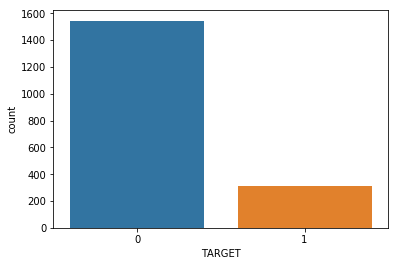

In [13]:
sns.countplot(data.TARGET)

In [10]:
data.TARGET.value_counts()[0]/data.TARGET.value_counts()[1]

5.0

El set está desbalanciado, en relación 5 a 1 a favor de TARGET = 0. Es decir, la mayoría de los datos es para clientes que devuelven el préstamo.

In [14]:
data.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 11 columns):
TARGET     1854 non-null int64
LOAN       1854 non-null int64
MORTDUE    1854 non-null float64
VALUE      1854 non-null float64
YOJ        1854 non-null float64
DEROG      1854 non-null float64
DELINQ     1854 non-null float64
CLAGE      1854 non-null float64
NINQ       1854 non-null float64
CLNO       1854 non-null float64
DEBTINC    1854 non-null float64
dtypes: float64(9), int64(2)
memory usage: 159.4 KB


**Buscando NaNs**

In [23]:
data.isnull().sum().sum()

0

**Correlación entre features**

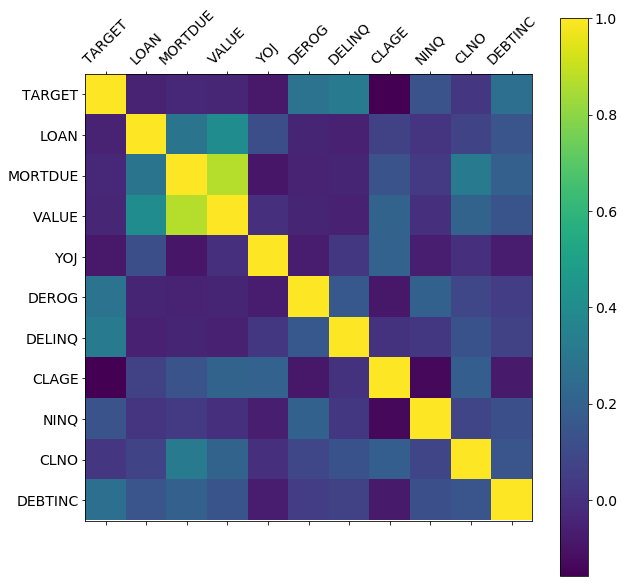

In [93]:
f = plt.figure(figsize=(10, 10))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

No hay correlaciones fuertes con la variable TARGET:

In [91]:
print('Coeficiente de correlación vs TARGET')
print('\nMayor a 0.1:')
index=(data.corr()['TARGET']>0.3).values
print(data.columns[index])
print('Mayor a 0.3:')
index=(data.corr()['TARGET']>0.1).values
print(data.columns[index])


Coeficiente de correlación vs TARGET

Mayor a 0.1:
Index(['TARGET', 'DELINQ'], dtype='object')
Mayor a 0.3:
Index(['TARGET', 'DEROG', 'DELINQ', 'NINQ', 'DEBTINC'], dtype='object')


Si parece haber una correlación interesante entre las variables MORTDUE y VALUE según la matriz, lo que sugiere la posibilidad de una reducción de la dimensionalidad

In [109]:
data['VALUE'].corr(data['MORTDUE'])

0.8704382753329427

En menor medida, entre VALUE y LOAN. En este caso es poco significativo

In [110]:
data['VALUE'].corr(data['LOAN'])

0.405930577419662

In [115]:
data.corr()>0.5

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
TARGET,True,False,False,False,False,False,False,False,False,False,False
LOAN,False,True,False,False,False,False,False,False,False,False,False
MORTDUE,False,False,True,True,False,False,False,False,False,False,False
VALUE,False,False,True,True,False,False,False,False,False,False,False
YOJ,False,False,False,False,True,False,False,False,False,False,False
DEROG,False,False,False,False,False,True,False,False,False,False,False
DELINQ,False,False,False,False,False,False,True,False,False,False,False
CLAGE,False,False,False,False,False,False,False,True,False,False,False
NINQ,False,False,False,False,False,False,False,False,True,False,False
CLNO,False,False,False,False,False,False,False,False,False,True,False


MORTDUE y VALUE efectivamente muestran la mayor correlación y la única de importancia

**Búsqueda de outliers**

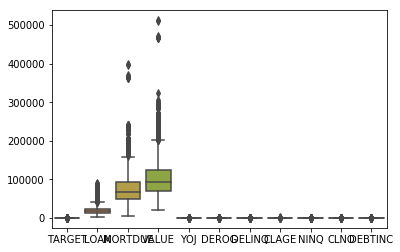

In [124]:
sns.boxplot(data=data)

Las magnitudes son de diferente orden en las variables. En un mismo gráfico, observar las distribuciones normalizadas. Como alternativa, examinar una por una.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

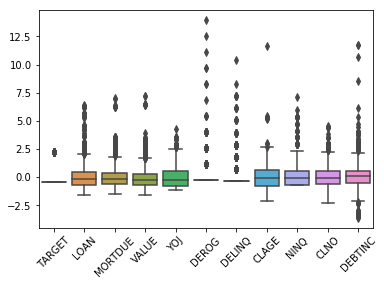

In [147]:
ax = sns.boxplot(data=ndata)
#ax.set_xticklabels(data.columns)
plt.xticks(rotation=45)

In [161]:
ndata.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03,1.854000e+03
mean,1.807017e-15,3.832485e-18,-2.887837e-17,-1.101839e-17,1.612619e-17,4.151599e-15,3.629004e-15,1.269511e-16,-2.171342e-16,-6.305636e-17,1.107828e-17
std,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00,1.000270e+00
min,-4.472136e-01,-1.583264e+00,-1.529584e+00,-1.538202e+00,-1.178737e+00,-2.663607e-01,-3.445899e-01,-2.120063e+00,-6.783883e-01,-2.298741e+00,-3.625002e+00
25%,-4.472136e-01,-6.466776e-01,-5.914003e-01,-6.521039e-01,-7.814193e-01,-2.663607e-01,-3.445899e-01,-7.466810e-01,-6.783883e-01,-6.159967e-01,-5.529811e-01
50%,-4.472136e-01,-1.920238e-01,-1.972333e-01,-2.342381e-01,-2.516629e-01,-2.663607e-01,-3.445899e-01,-6.287733e-02,-7.746527e-02,-9.013894e-02,8.488880e-02
75%,-4.472136e-01,4.353984e-01,3.768390e-01,2.794339e-01,5.429718e-01,-2.663607e-01,-3.445899e-01,6.126364e-01,5.234578e-01,5.408903e-01,5.141235e-01
max,2.236068e+00,6.427735e+00,6.991216e+00,7.234842e+00,4.251267e+00,1.392423e+01,1.042893e+01,1.164803e+01,7.133612e+00,4.537409e+00,1.177867e+01


## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


Lista para almacenar scores de diferentes modelos

In [9]:
globalresult_sgd = []

### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [10]:
np.random.seed(0)
clf=SGDClassifier()

In [11]:
clf.fit(X_train,y_train)
globalresult_sgd.append(clf.score(X_test,y_test))
globalresult_sgd.append(clf.score(X_train,y_train))

In [57]:
y_pred = clf.predict(X_test)

**SGD Sin tunear, raw, TEST**

In [200]:
print(classification_report(y_test, clf.predict(X_test)))
print(confusion_matrix(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       313
           1       0.00      0.00      0.00        58

   micro avg       0.84      0.84      0.84       371
   macro avg       0.42      0.50      0.46       371
weighted avg       0.71      0.84      0.77       371

[[312   1]
 [ 58   0]]


**SGD Sin tunear, raw, TRAIN**

In [12]:
print(classification_report(y_train, clf.predict(X_train)))
print(confusion_matrix(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1232
           1       0.00      0.00      0.00       251

    accuracy                           0.83      1483
   macro avg       0.42      0.50      0.45      1483
weighted avg       0.69      0.83      0.75      1483

[[1232    0]
 [ 251    0]]


In [168]:
y_train.value_counts()

0    1232
1     251
Name: TARGET, dtype: int64

### Con datos normalizados
Mejora inmediatamente la precisión, incluso sin tuneo de hiperparámetros el modelo realiza una predicción distinta a la clasificación de todos los datos como una única clase. La precisión para clase 1, ahora es mejor que el azar (0.5) para el set de entrenamiento. Para el set de test, es de 0.28; aunque distinta de 0 sigue siendo bastante mala.

In [13]:
sc = StandardScaler()
nX_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
nX_test = pd.DataFrame(sc.fit_transform(X_test), columns=X_test.columns)

**SGD Sin tunear, NORMALIZADO, TEST**

In [14]:
clf=SGDClassifier()
clf.fit(nX_train,y_train)
globalresult_sgd.append(clf.score(nX_test,y_test))
globalresult_sgd.append(clf.score(nX_train,y_train))

In [77]:
y_pred = clf.predict(nX_test)
print(classification_report(y_test, clf.predict(nX_test)))
print(confusion_matrix(y_test, clf.predict(nX_test)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       313
           1       0.63      0.33      0.43        58

    accuracy                           0.87       371
   macro avg       0.76      0.65      0.68       371
weighted avg       0.85      0.87      0.85       371

[[302  11]
 [ 39  19]]


**SGD Sin tunear, NORMALIZADO, TRAIN**

In [78]:
y_pred = clf.predict(nX_train)
print(classification_report(y_train, clf.predict(nX_train)))
print(confusion_matrix(y_train, clf.predict(nX_train)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1232
           1       0.63      0.38      0.47       251

    accuracy                           0.86      1483
   macro avg       0.76      0.67      0.70      1483
weighted avg       0.84      0.86      0.84      1483

[[1177   55]
 [ 156   95]]


### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

**RAW, TEST AND TRAIN**

In [15]:
results = pd.DataFrame(columns=('clf','best_acc'))
param = {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')}
sclf = SGDClassifier()
sclf_ = GridSearchCV(sclf, param, scoring='accuracy', cv=5, iid=False)
sclf_.fit(X_train, y_train)
best_clf = sclf_.best_estimator_
print('best: ',sclf_.best_score_)
print(best_clf)
results = results.append({'clf': best_clf, 'best_acc': sclf_.best_score_},
                        ignore_index=True)
print('best so far: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])
print('\n\n')
print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(X_test)))
print(confusion_matrix(y_test, best_clf.predict(X_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(X_train)))
print(confusion_matrix(y_train, best_clf.predict(X_train)))

best:  0.8314215679987491
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)
best so far: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)



Report and confusion matrix por TEST SET
              precision 

In [16]:
globalresult_sgd.append(sclf_.cv_results_['mean_test_score'])

**NORMALIZADO, TEST AND TRAIN**

In [17]:
results = pd.DataFrame(columns=('clf','best_acc'))
param = {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')}
sclf = SGDClassifier()
sclf_ = GridSearchCV(sclf, param, scoring='accuracy', cv=5, iid=False)
sclf_.fit(nX_train, y_train)
best_clf = sclf_.best_estimator_
print('best: ',sclf_.best_score_)
print(best_clf)
results = results.append({'clf': best_clf, 'best_acc': sclf_.best_score_},
                        ignore_index=True)
print('best so far: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])
print('\n\n')
print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(nX_test)))
print(confusion_matrix(y_test, best_clf.predict(nX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(nX_train)))
print(confusion_matrix(y_train, best_clf.predict(nX_train)))

best:  0.8698624188557075
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
best so far: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

 

In [18]:
globalresult_sgd.append(sclf_.cv_results_['mean_test_score'])

## Ejercicio 3: Árbol de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

Lista para almacenar scores de diferentes modelos

In [19]:
globalresult_tree = []

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


**NO TUNING, RAW**

In [20]:
tree = DT(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_train)
print('Summary and confusion matrix por TEST SET')
print(classification_report(y_test, tree.predict(X_test)))
print(confusion_matrix(y_test, tree.predict(X_test)))
print('\nSummary and confusion matrix por TRAIN SET')
print(classification_report(y_train, tree.predict(X_train)))
print(confusion_matrix(y_train, tree.predict(X_train)))

Summary and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       313
           1       0.64      0.62      0.63        58

    accuracy                           0.89       371
   macro avg       0.79      0.78      0.78       371
weighted avg       0.89      0.89      0.89       371

[[293  20]
 [ 22  36]]

Summary and confusion matrix por TRAIN SET
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483

[[1232    0]
 [   0  251]]


In [21]:
globalresult_tree.append(tree.score(X_test, y_test))
globalresult_tree.append(tree.score(X_train, y_train))

**NO TUNING, NORMALIZED**

In [22]:
tree = DT(random_state=42)
tree.fit(nX_train, y_train)
y_pred = tree.predict(nX_train)
print('Summary and confusion matrix por TEST SET')
print(classification_report(y_test, tree.predict(nX_test)))
print(confusion_matrix(y_test, tree.predict(nX_test)))
print('\nSummary and confusion matrix por TRAIN SET')
print(classification_report(y_train, tree.predict(nX_train)))
print(confusion_matrix(y_train, tree.predict(nX_train)))

Summary and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       313
           1       0.54      0.76      0.63        58

    accuracy                           0.86       371
   macro avg       0.75      0.82      0.77       371
weighted avg       0.89      0.86      0.87       371

[[276  37]
 [ 14  44]]

Summary and confusion matrix por TRAIN SET
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483

[[1232    0]
 [   0  251]]


In [23]:
globalresult_tree.append(tree.score(X_test, y_test))
globalresult_tree.append(tree.score(X_train, y_train))

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

**RAW**

In [24]:
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)} #best 680

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(X_train, y_train)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(X_test)))
print(confusion_matrix(y_test, best_clf.predict(X_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(X_train)))
print(confusion_matrix(y_train, best_clf.predict(X_train)))

Best Decision Tree accuracy:  0.8692275558047371
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
The best classifier so far is: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Report and confusion matrix por TEST SET
              precision    recall  f1-score

In [25]:
globalresult_tree.append(tree_clf.cv_results_['mean_test_score'])

**NORMALIZED**

In [26]:
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)} #best 680

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(nX_train, y_train)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(nX_test)))
print(confusion_matrix(y_test, best_clf.predict(nX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(nX_train)))
print(confusion_matrix(y_train, best_clf.predict(nX_train)))

Best Decision Tree accuracy:  0.8692275558047371
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
The best classifier so far is: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Report and confusion matrix por TEST SET
              precision    recall  f1-score

In [28]:
globalresult_tree.append(tree_clf.cv_results_['mean_test_score'])

## Dimensionality reduction

## PCA

In [29]:
pca = PCA() #(n_components=0.75, svd_solver='full')
pX_train = pca.fit_transform(nX_train)
pX_test = pca.transform(nX_test)

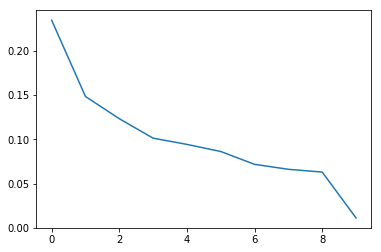

In [24]:
explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

In [39]:
explained_variance

array([0.23410332, 0.14823301, 0.1232092 , 0.10129132, 0.094279  ,
       0.08627101, 0.07180717, 0.06623148, 0.06309833, 0.01147616])

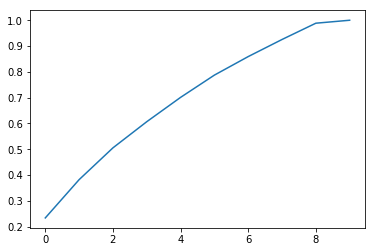

In [40]:
plt.plot(np.cumsum(explained_variance))

In [44]:
import warnings
warnings.filterwarnings('ignore')

**SGD**

In [30]:
results = pd.DataFrame(columns=('clf','best_acc'))
param = {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')}
sclf = SGDClassifier()
sclf_ = GridSearchCV(sclf, param, scoring='accuracy', cv=5, iid=False)
sclf_.fit(pX_train, y_train)
best_clf = sclf_.best_estimator_
print('best: ',sclf_.best_score_)
print(best_clf)
results = results.append({'clf': best_clf, 'best_acc': sclf_.best_score_},
                        ignore_index=True)
print('best so far: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])
print('\n\n')
print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(pX_test)))
print(confusion_matrix(y_test, best_clf.predict(pX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(pX_train)))
print(confusion_matrix(y_train, best_clf.predict(pX_train)))

best:  0.8624345516962967
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
best so far: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0     

In [31]:
globalresult_sgd.append(sclf_.cv_results_['mean_test_score'])

**Árbol de decisión**

In [32]:
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)} #best 680

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(pX_train, y_train)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(pX_test)))
print(confusion_matrix(y_test, best_clf.predict(pX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(pX_train)))
print(confusion_matrix(y_train, best_clf.predict(pX_train)))

Best Decision Tree accuracy:  0.8604234038797797
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
The best classifier so far is: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

In [34]:
globalresult_tree.append(tree_clf.cv_results_['mean_test_score'])

## Greedy Elimination

En el par de features correlacionadas, VALUE y MORTDUE, eliminar la de menor correlación con la salida, TARGET  
https://www.kaggle.com/reisel/how-to-handle-correlated-features

In [52]:
print(data['TARGET'].corr(data['VALUE']))
print(data['TARGET'].corr(data['MORTDUE']))

-0.035456574430790734
-0.02332452011074581


In [35]:
gX_train = X_train.drop(['MORTDUE'], axis=1)
gX_test = X_test.drop(['MORTDUE'], axis=1)
ngX_train = nX_train.drop(['MORTDUE'], axis=1)
ngX_test = nX_test.drop(['MORTDUE'], axis=1)

**SGD RAW**

In [36]:
results = pd.DataFrame(columns=('clf','best_acc'))
param = {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')}
sclf = SGDClassifier()
sclf_ = GridSearchCV(sclf, param, scoring='accuracy', cv=5, iid=False)
sclf_.fit(gX_train, y_train)
best_clf = sclf_.best_estimator_
print('best: ',sclf_.best_score_)
print(best_clf)
results = results.append({'clf': best_clf, 'best_acc': sclf_.best_score_},
                        ignore_index=True)
print('best so far: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])
print('\n\n')
print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(gX_test)))
print(confusion_matrix(y_test, best_clf.predict(gX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(gX_train)))
print(confusion_matrix(y_train, best_clf.predict(gX_train)))

best:  0.8307504270591519
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
best so far: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0     

In [37]:
globalresult_sgd.append(sclf_.cv_results_['mean_test_score'])

**SGD NORMALIZED**

In [38]:
results = pd.DataFrame(columns=('clf','best_acc'))
param = {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')}
sclf = SGDClassifier()
sclf_ = GridSearchCV(sclf, param, scoring='accuracy', cv=5, iid=False)
sclf_.fit(ngX_train, y_train)
best_clf = sclf_.best_estimator_
print('best: ',sclf_.best_score_)
print(best_clf)
results = results.append({'clf': best_clf, 'best_acc': sclf_.best_score_},
                        ignore_index=True)
print('best so far: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])
print('\n\n')
print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(ngX_test)))
print(confusion_matrix(y_test, best_clf.predict(ngX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(ngX_train)))
print(confusion_matrix(y_train, best_clf.predict(ngX_train)))

best:  0.8671960093101033
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
best so far: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0     

In [39]:
globalresult_sgd.append(sclf_.cv_results_['mean_test_score'])

**TREE RAW**

In [40]:
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)} #best 680

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(gX_train, y_train)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(gX_test)))
print(confusion_matrix(y_test, best_clf.predict(gX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(gX_train)))
print(confusion_matrix(y_train, best_clf.predict(gX_train)))

Best Decision Tree accuracy:  0.8746103027982223
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
The best classifier so far is: 
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           

In [41]:
globalresult_tree.append(tree_clf.cv_results_['mean_test_score'])

**TREE NORMALIZED**

In [42]:
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)} #best 680

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(ngX_train, y_train)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(ngX_test)))
print(confusion_matrix(y_test, best_clf.predict(ngX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_train, best_clf.predict(ngX_train)))
print(confusion_matrix(y_train, best_clf.predict(ngX_train)))

Best Decision Tree accuracy:  0.8746103027982223
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
The best classifier so far is: 
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           

In [43]:
globalresult_tree.append(tree_clf.cv_results_['mean_test_score'])

# Balancing the set
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

In [44]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

Using TensorFlow backend.


In [45]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [46]:
X_sm = pd.DataFrame(X_sm, columns=X_train.columns)
y_sm = pd.Series(y_sm)

Función utilizada para poder tener alguna noción gráfica del efecto del oversampling. Proyectada en las dos componentes principales de más peso para poder verse en 2D

In [40]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [45]:
pca = PCA(n_components=2)
pX_train = pca.fit_transform(X_train)

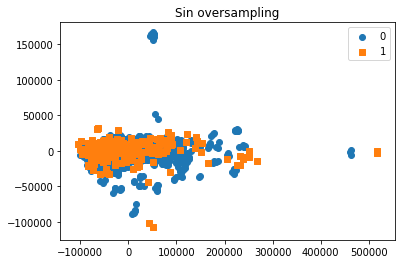

In [48]:
plot_2d_space(pX_train, y_train, label='Sin oversampling')

In [44]:
pca = PCA(n_components=2)
pX_sm = pca.fit_transform(X_sm)

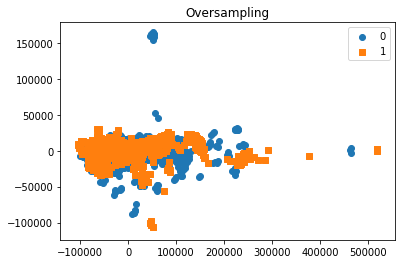

In [49]:
plot_2d_space(pX_sm, y_sm, label='Oversampling')

In [31]:
print(y_train.value_counts())
print(y_sm.value_counts())

0    1232
1     251
Name: TARGET, dtype: int64
1    1232
0    1232
dtype: int64


**OVERSAMPLING SGD RAW**

In [76]:
results = pd.DataFrame(columns=('clf','best_acc'))
param = {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')} #'max_iter':(10000,100000)
sclf = SGDClassifier()
sclf_ = GridSearchCV(sclf, param, scoring='accuracy', cv=5, iid=False)
sclf_.fit(X_sm, y_sm)
best_clf = sclf_.best_estimator_
print('best: ',sclf_.best_score_)
print(best_clf)
results = results.append({'clf': best_clf, 'best_acc': sclf_.best_score_},
                        ignore_index=True)
print('best so far: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])
print('\n\n')
print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(X_test)))
print(confusion_matrix(y_test, best_clf.predict(X_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_sm, best_clf.predict(X_sm)))
print(confusion_matrix(y_sm, best_clf.predict(X_sm)))

best:  0.5157927652151015
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
best so far: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0     

In [48]:
globalresult_sgd.append(sclf_.cv_results_['mean_test_score'])

**OVERSAMPLING SGD NORMALIZADO**

In [49]:
smote = SMOTE(ratio='minority')
X_smn, y_smn = smote.fit_sample(nX_train, y_train)
X_smn = pd.DataFrame(X_smn, columns=nX_train.columns)
y_smn = pd.Series(y_smn)


In [78]:
results = pd.DataFrame(columns=('clf','best_acc'))
param = {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')} #'max_iter':(10000,100000)
sclf = SGDClassifier()
sclf_ = GridSearchCV(sclf, param, scoring='accuracy', cv=5, iid=False)
sclf_.fit(X_smn, y_smn)
best_clf = sclf_.best_estimator_
print('best: ',sclf_.best_score_)
print(best_clf)
results = results.append({'clf': best_clf, 'best_acc': sclf_.best_score_},
                        ignore_index=True)
print('best so far: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])
print('\n\n')
print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(nX_test)))
print(confusion_matrix(y_test, best_clf.predict(nX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_smn, best_clf.predict(X_smn)))
print(confusion_matrix(y_smn, best_clf.predict(X_smn)))

best:  0.7150817945426419
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
best so far: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)



Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0 

In [51]:
globalresult_sgd.append(sclf_.cv_results_['mean_test_score'])

**OVERSAMPLING TREE RAW**

In [52]:
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)} #best 680

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(X_sm, y_sm)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(X_test)))
print(confusion_matrix(y_test, best_clf.predict(X_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_sm, best_clf.predict(X_sm)))
print(confusion_matrix(y_sm, best_clf.predict(X_sm)))

Best Decision Tree accuracy:  0.894121325828643
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
The best classifier so far is: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0      

In [54]:
globalresult_tree.append(tree_clf.cv_results_['mean_test_score'])


**OVERSAMPLING TREE NORMALIZADO**

In [55]:
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)} #best 680

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, scoring='accuracy', cv=5, iid=False)
tree_clf.fit(X_smn, y_smn)
best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

print('Report and confusion matrix por TEST SET')
print(classification_report(y_test, best_clf.predict(nX_test)))
print(confusion_matrix(y_test, best_clf.predict(nX_test)))
print('\nReport and confusion matrix por TRAIN SET')
print(classification_report(y_smn, best_clf.predict(X_smn)))
print(confusion_matrix(y_smn, best_clf.predict(X_smn)))

Best Decision Tree accuracy:  0.8945179553010105
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
The best classifier so far is: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Report and confusion matrix por TEST SET
              precision    recall  f1-score   support

           0     

In [56]:
globalresult_tree.append(tree_clf.cv_results_['mean_test_score'])

# Neural Networks

In [57]:
globalresult_nn = []

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
clf = neural_network.MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=5000)

**RAW**

In [59]:
clf.fit(X_train, y_train)
#clf.predict(nX_train)
print('TRAIN')
print(classification_report(y_train, clf.predict(X_train)))
print(confusion_matrix(y_train, clf.predict(X_train)))
print('\nTEST')
print(classification_report(y_test, clf.predict(X_test)))
print(confusion_matrix(y_test, clf.predict(X_test)))

TRAIN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1232
           1       0.17      1.00      0.29       251

    accuracy                           0.17      1483
   macro avg       0.08      0.50      0.14      1483
weighted avg       0.03      0.17      0.05      1483

[[   0 1232]
 [   0  251]]

TEST
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       313
           1       0.16      1.00      0.27        58

    accuracy                           0.16       371
   macro avg       0.08      0.50      0.14       371
weighted avg       0.02      0.16      0.04       371

[[  0 313]
 [  0  58]]


In [60]:
globalresult_nn.append(clf.score(X_test, y_test))
globalresult_nn.append(clf.score(X_train, y_train))

**NORMALIZED**

In [61]:
clf.fit(nX_train, y_train)
#clf.predict(nX_train)
print('TRAIN')
print(classification_report(y_train, clf.predict(nX_train)))
print(confusion_matrix(y_train, clf.predict(nX_train)))
print('\nTEST')
print(classification_report(y_test, clf.predict(nX_test)))
print(confusion_matrix(y_test, clf.predict(nX_test)))

TRAIN
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1232
           1       0.91      0.55      0.69       251

    accuracy                           0.92      1483
   macro avg       0.92      0.77      0.82      1483
weighted avg       0.92      0.92      0.91      1483

[[1219   13]
 [ 112  139]]

TEST
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       313
           1       0.78      0.53      0.63        58

    accuracy                           0.90       371
   macro avg       0.85      0.75      0.79       371
weighted avg       0.90      0.90      0.90       371

[[304   9]
 [ 27  31]]


In [62]:
globalresult_nn.append(clf.score(nX_test, y_test))
globalresult_nn.append(clf.score(nX_train, y_train))

**PCA - 10 COMPONENTS >0.75 VAR EXPLAINED**

In [63]:
clf.fit(pX_train, y_train)
#clf.predict(nX_train)
print('TRAIN')
print(classification_report(y_train, clf.predict(pX_train)))
print(confusion_matrix(y_train, clf.predict(pX_train)))
print('\nTEST')
print(classification_report(y_test, clf.predict(pX_test)))
print(confusion_matrix(y_test, clf.predict(pX_test)))

TRAIN
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1232
           1       0.85      0.53      0.66       251

    accuracy                           0.90      1483
   macro avg       0.88      0.76      0.80      1483
weighted avg       0.90      0.90      0.90      1483

[[1208   24]
 [ 117  134]]

TEST
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       313
           1       0.76      0.50      0.60        58

    accuracy                           0.90       371
   macro avg       0.84      0.74      0.77       371
weighted avg       0.89      0.90      0.89       371

[[304   9]
 [ 29  29]]


In [64]:
globalresult_nn.append(clf.score(nX_test, y_test))
globalresult_nn.append(clf.score(nX_train, y_train))

**SMOTE RAW**

In [65]:
clf.fit(X_sm, y_sm)
#clf.predict(nX_train)
print('TRAIN')
print(classification_report(y_sm, clf.predict(X_sm)))
print(confusion_matrix(y_sm, clf.predict(X_sm)))
print('\nTEST')
print(classification_report(y_test, clf.predict(X_test)))
print(confusion_matrix(y_test, clf.predict(X_test)))

TRAIN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1232
           1       0.50      1.00      0.67      1232

    accuracy                           0.50      2464
   macro avg       0.25      0.50      0.33      2464
weighted avg       0.25      0.50      0.33      2464

[[   0 1232]
 [   0 1232]]

TEST
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       313
           1       0.16      1.00      0.27        58

    accuracy                           0.16       371
   macro avg       0.08      0.50      0.14       371
weighted avg       0.02      0.16      0.04       371

[[  0 313]
 [  0  58]]


In [66]:
globalresult_nn.append(clf.score(nX_test, y_test))
globalresult_nn.append(clf.score(nX_train, y_train))

**SMOTE NORMALIZED**

In [67]:
clf.fit(X_smn, y_smn)
#clf.predict(nX_train)
print('TRAIN')
print(classification_report(y_smn, clf.predict(X_smn)))
print(confusion_matrix(y_smn, clf.predict(X_smn)))
print('\nTEST')
print(classification_report(y_test, clf.predict(nX_test)))
print(confusion_matrix(y_test, clf.predict(nX_test)))

TRAIN
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1232
           1       0.79      0.82      0.80      1232

    accuracy                           0.80      2464
   macro avg       0.80      0.80      0.80      2464
weighted avg       0.80      0.80      0.80      2464

[[ 964  268]
 [ 225 1007]]

TEST
              precision    recall  f1-score   support

           0       0.95      0.74      0.84       313
           1       0.37      0.79      0.50        58

    accuracy                           0.75       371
   macro avg       0.66      0.77      0.67       371
weighted avg       0.86      0.75      0.78       371

[[233  80]
 [ 12  46]]


In [68]:
globalresult_nn.append(clf.score(nX_test, y_test))
globalresult_nn.append(clf.score(nX_train, y_train))

# ============
# Comparativa Gráfica

In [85]:
from itertools import product
def dproduct(inp):
    return (dict(zip(inp.keys(), values)) for values in product(*inp.values()))

In [86]:
sgd_param =  {'loss':('hinge','log','epsilon_insensitive'), 
         'penalty':('l1','l2','elasticnet')}
tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 8),
              'min_samples_split': (2,10,100)}

In [87]:
sgdlabel = list(dproduct(sgd_param))
sgdlabel = [list(x.values())[0]+'_'+list(x.values())[1] for x in sgdlabel]
treelabel = list(dproduct(tree_param))
treelabel = [list(x.values())[0]+'_'+str(list(x.values())[1])+'_'+str(list(x.values())[2]) for x in treelabel]
#label

## SGD Classifier

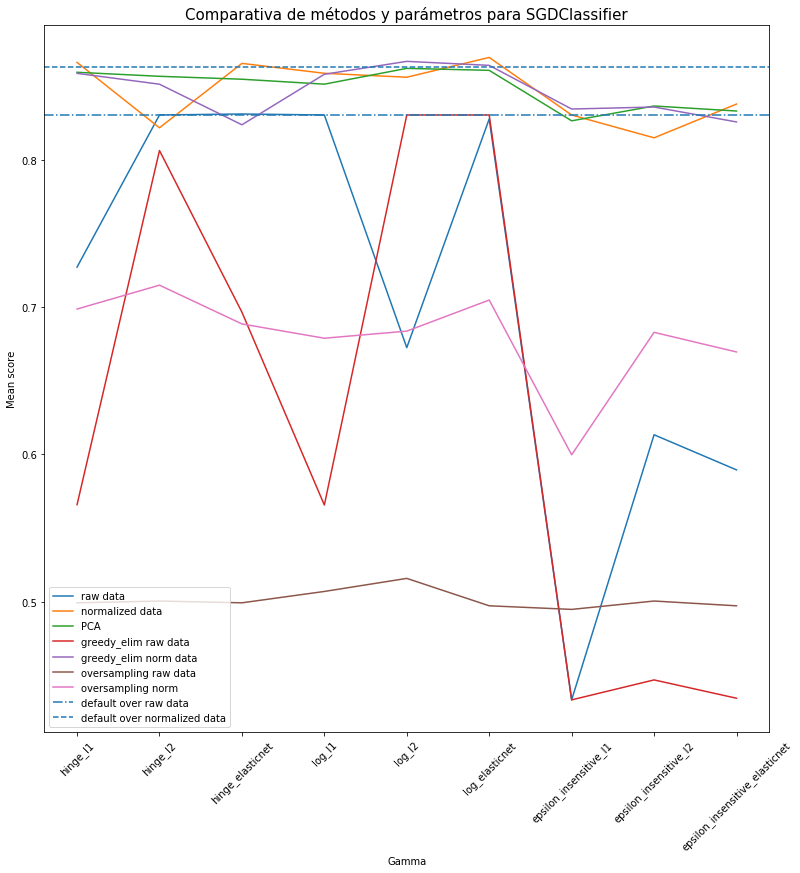

In [102]:
plt.figure(figsize=(13,13))
plt.title('Comparativa de métodos y parámetros para SGDClassifier', loc='center', fontsize='15')
plt.plot(np.arange(9),globalresult_sgd[4], label='raw data')
plt.plot(np.arange(9),globalresult_sgd[5], label='normalized data')
plt.plot(np.arange(9),globalresult_sgd[6], label='PCA')
plt.plot(np.arange(9),globalresult_sgd[7], label='greedy_elim raw data')
plt.plot(np.arange(9),globalresult_sgd[8], label='greedy_elim norm data')
plt.plot(np.arange(9),globalresult_sgd[9], label='oversampling raw data')
plt.plot(np.arange(9),globalresult_sgd[10], label='oversampling norm')
plt.axhline(globalresult_sgd[1], linestyle = '-.', label='default over raw data')
plt.axhline(globalresult_sgd[3], linestyle = '--', label='default over normalized data')
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.xticks(np.arange(9),sgdlabel, rotation=45)
#plt.tight_layout()
plt.show()

### Análisis

Para las combinaciones de parámetros exploradas, los mejores resultados con absoluta diferencia se obvtuvieron trabajando sobre los datos normalizados. De hecho el clasificador con los hiperparámetros por defecto sobre los datos normalizados es uno de los modelos que mejor trabaja. Junto a él, entre los mejores se encuentran casi todos los otros casos de normalización excepto en el que se realiza un sobremuestreo de los datos. Cabe destacar que se probó solamente una técnica de sobremuestreo y ninguna de undersampling ni técnicas mixtas.  
La reducción de dimensionalidad muestra ser de utilidad en este caso, como se podía sospechar a partir de la matriz de correlación de la primera sección.  


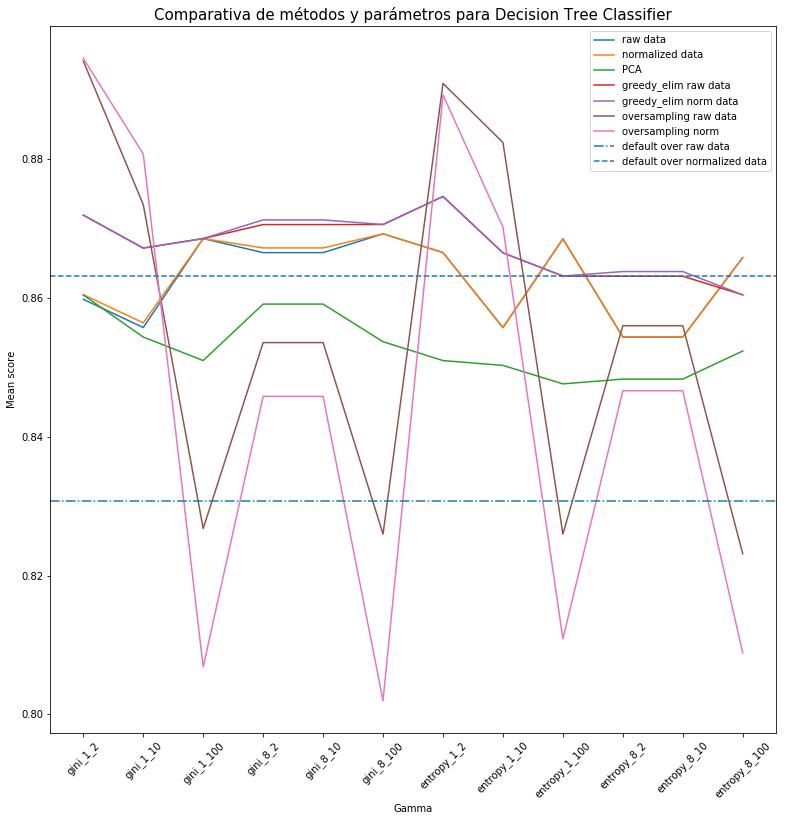

In [107]:
plt.figure(figsize=(13,13))
plt.title('Comparativa de métodos y parámetros para Decision Tree Classifier', loc='center', fontsize='15')
plt.plot(np.arange(12),globalresult_tree[4], label='raw data')
plt.plot(np.arange(12),globalresult_tree[5], label='normalized data')
plt.plot(np.arange(12),globalresult_tree[6], label='PCA')
plt.plot(np.arange(12),globalresult_tree[7], label='greedy_elim raw data')
plt.plot(np.arange(12),globalresult_tree[8], label='greedy_elim norm data')
plt.plot(np.arange(12),globalresult_tree[9], label='oversampling raw data')
plt.plot(np.arange(12),globalresult_tree[10], label='oversampling norm')
plt.axhline(globalresult_sgd[1], linestyle = '-.', label='default over raw data')
plt.axhline(globalresult_sgd[3], linestyle = '--', label='default over normalized data')
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.xticks(np.arange(12),treelabel, rotation=45)
#plt.tight_layout()
plt.show()

### Análisis

Los modelos de predicción por Decision Tree tienen un rendimiento general muy superior al caso anterior. Basta con comparar las escalas de ambos gráficos para notar la marcada diferencia.  
En este caso, la normalización resulta bien siendo relativamente estables los scores obtenidos por los metodos que trabajan con esos datos a través de todas las combinaciones de parámetros utilizados. La única excepción a este comportamiento es el oversampling que tanto con datos normalizados como crudos tiene una sensibilidad a la variación de hiperparámetros muy superior; es particularmente sensible al parámetro *min_samples_split* lo que quizás esté relacionado con la metodología de sobremuestreo de alguna manera.  
Las técnicas de reducción de dimensionalidad también funcionan bien en este caso, con la diferencia sorpresiva de que Greedy eliminarion se comporta de manera muy similar trabajando tanto sobre datos normalizados como sobre datos crudos.  

([<matplotlib.axis.XTick at 0x2109db8d7b8>,
 <a list of 10 Text xticklabel objects>)

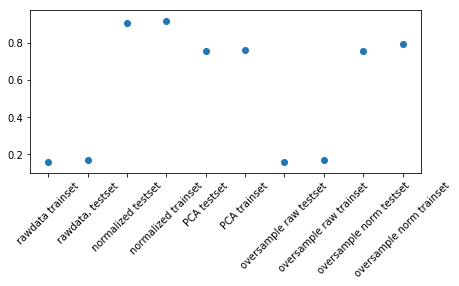

In [149]:
nnlabels = ['rawdata trainset', 'rawdata, testset', 'normalized testset', 'normalized trainset'
           ,'PCA testset', 'PCA trainset', 'oversample raw testset', 'oversample raw trainset'
           ,'oversample norm testset', 'oversample norm trainset']
plt.figure(figsize=(7,3))
plt.scatter(x=range(len(globalresult_nn)),y=globalresult_nn)
plt.xticks(range(len(globalresult_nn)), nnlabels, rotation = 45)

### Análisis

Las redes neuronales se probaron con hiperparámetros por defecto como comparación rápida sobre los primeros métodos de referencia. Resultaron en un rendimiento pésimo sobre los sets de datos sin normalizar y excelentes -entre los mejores- para los sets de datos normalizados.  
Nuevamente se muestra una buena capacidad predictiva remanente luego de la reducción de dimensionalidad. De todas maneras, según la naturaleza del problema puede no ser sacrificable.

## Mejoras en las pruebas

Hay dos modificaciones inmediatas para ampliar el análisis.  
1. Las advertencias, desactivadas en el notebook para mejor comodidad, en muchos casos advierten acerca de que se ha alcanzado el número máximo de iteraciones. Para mejorar las pruebas sería bueno agregar este parámetro a GridSearchCV o directamente trabajar con un valor superior pues el tiempo de trabajo es insignificante de todas maneras en el caso actual.  
2. En Decision Trees, min_samples_split funciona bien para valores muy superiores a los explorados y quizás valga la pena mayor variación en las magnitudes.